### Members
***
+ UID: 205928946, name: Yu-Wei Chen
+ UID: 705668757, name: Kuei-Chun Huang
+ UID: 805861373, name: Sinya Peng

In [1]:
# !pip install matplotlib==3.6.0
# !pip install scikit-learn==1.2.0
# !pip install numpy pandas
# !pip install surprise
# !pip install tqdm

In [2]:
import os
import random  

from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import Markdown as md
from sklearn.metrics import roc_curve, auc, roc_auc_score, mean_squared_error
from surprise import Reader, Dataset, accuracy
from surprise.model_selection import cross_validate, KFold, train_test_split
from surprise.prediction_algorithms.knns import KNNWithMeans
from surprise.prediction_algorithms.matrix_factorization import NMF, SVD
from tqdm.auto import tqdm

In [3]:
SEED = 0
np.random.seed(SEED)
plt.style.use("seaborn-v0_8-bright")
random.seed(SEED)

### QUESTION 1: Explore the Dataset: In this question, we explore the structure of the data.
#### A. Compute the sparsity of the movie rating dataset
> Ans: The sparsity is 0.016999683055613623.

In [4]:
ratings_data = pd.read_csv("movie_data/ratings.csv") 
movies_data = pd.read_csv("movie_data/movies.csv")
links_data = pd.read_csv("movie_data/links.csv") 
tags_data = pd.read_csv("movie_data/tags.csv") 

user_ID = ratings_data["userId"].values
movie_ID = ratings_data["movieId"].values
ratings = ratings_data["rating"].values

available_ratings = len(ratings)
possible_ratings = len(np.unique(user_ID)) * len(np.unique(movie_ID))

sparsity = available_ratings / possible_ratings

print("Total number of available ratings:", available_ratings)
print("Total number of possible ratings:", possible_ratings)
print("Sparsity:", sparsity)

Total number of available ratings: 100836
Total number of possible ratings: 5931640
Sparsity: 0.016999683055613623


#### B. Plot a histogram showing the frequency of the rating values
Bin the raw rating values into intervals of width 0.5 and use the binned rating values as the horizontal axis. Count the
number of entries in the ratings matrix R that fall within each bin and use this count as the height of the vertical axis for that particular bin. Comment on the shape of the histogram.
> Ans: From the histogram we can see a left-skewed distribution. Rating values between 3.0 ~ 5.0 have higher frequencies, with 4.0 being the most rated. We can assume that users are more likely to watch movies that they are initially interested in or have heard better reviews of, and therefore tend to rate the movies better than average. We can also observe that more ratings are given with integer numbers rather than with decimal numbers.

- https://piazza.com/class/lcjwqyyip6bid/post/164

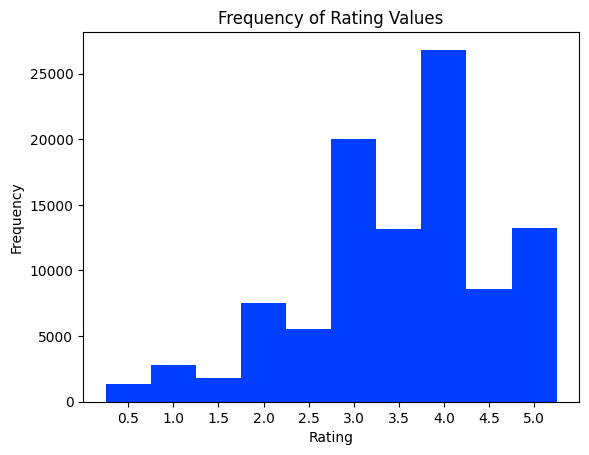

In [5]:
bins = np.arange(min(ratings), max(ratings)+1, 0.5)
plt.hist(ratings, bins, align="left")
plt.xticks(np.unique(ratings))
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.title("Frequency of Rating Values")
plt.show()

#### C. Plot the distribution of the number of ratings received among movies
The X-axis should be the movie index ordered by decreasing frequency and the Y -axis should be the number of ratings the movie has received; ties can broken in any way. A monotonically decreasing trend is expected.
> Ans: The plot is shown below. Since the movie index is ordered by decreasing frequency, we can indeed see a monotonically decreasing trend.

- https://piazza.com/class/lcjwqyyip6bid/post/163

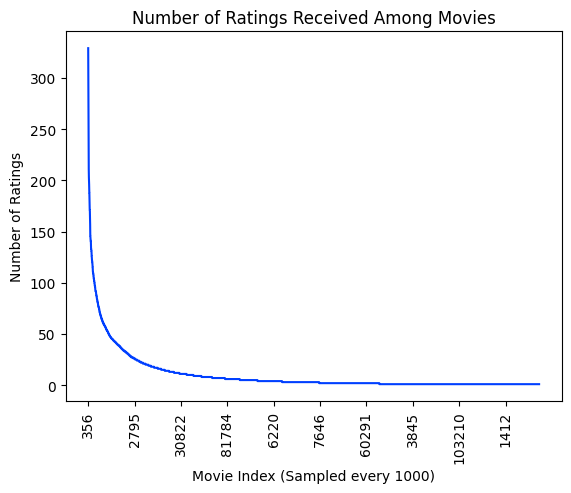

In [6]:
mid_sortby_cnt = ratings_data["movieId"].value_counts()
sample_num = 1000

plt.plot(mid_sortby_cnt.values)
plt.xlabel(f"Movie Index (Sampled every {sample_num})")
plt.xticks(list(range(len(mid_sortby_cnt)))[::sample_num], mid_sortby_cnt.index[::sample_num], rotation=90)

plt.ylabel("Number of Ratings")
plt.title("Number of Ratings Received Among Movies")
plt.show()

#### D. Plot the distribution of ratings among users
The X-axis should be the user index ordered by decreasing frequency and the Y -axis should be the number of movies the user has rated. The requirement of the plot is similar to that in Question C.
> Ans: The plot is shown below. Similar to Question C, the user index is ordered by decreasing frequency, and the monotonically decreasing trend is also observed.

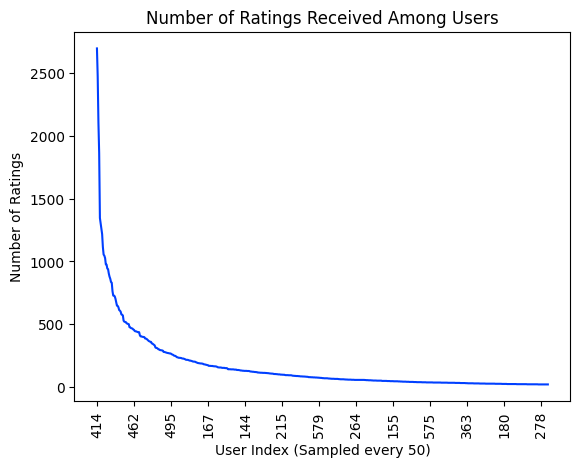

In [7]:
uid_sortby_cnt = ratings_data["userId"].value_counts()
sample_num = 50

plt.plot(uid_sortby_cnt.values)
plt.xlabel(f"User Index (Sampled every {sample_num})")
plt.xticks(list(range(len(uid_sortby_cnt)))[::sample_num], uid_sortby_cnt.index[::sample_num], rotation=90)

plt.ylabel("Number of Ratings")
plt.title("Number of Ratings Received Among Users")
plt.show()

#### E. Discuss the salient features of the distributions from Questions C,D and their implications for the recommendation process.
> Ans: From the plots above, it is observed that only about half of the movies are rated, and only about half of the users are rating. Especially from plot C, we can see that the first 2000 movies received most of the ratings, and the rest of the movies received almost nothing. This will lead to sparsity of the data needed for the recommendation process, which is not desired since a huge amount of the elements contribute little or no information to model training. In this case, we will need even more data to reach adequate accuracy. We can also consider performing regularization to help our model generalize better and render better results.  

#### F. Compute the variance of the rating values received by each movie
Bin the variance values into intervals of width 0.5 and use the binned variance values as the horizontal axis. Count the number of movies with variance values in the binned intervals and use this count as the vertical axis. Briefly comment on the shape of the resulting histogram.
> Ans: Most movies have a rating variance of less than 1, meaning that the ratings among different users are consistent. This corresponds to the plot resulting from question B, where most of the ratings fall around the range of 3.0 ~ 4.0 and do not vary widely. The shape of the resulting histogram also show a monotonically decreasing trend.

In [8]:
movie_ID_unique = np.unique(movie_ID)
ratings_var = []

for mid in movie_ID_unique:
    ratings_var.append(np.var(ratings_data[ratings_data["movieId"] == mid]["rating"]))

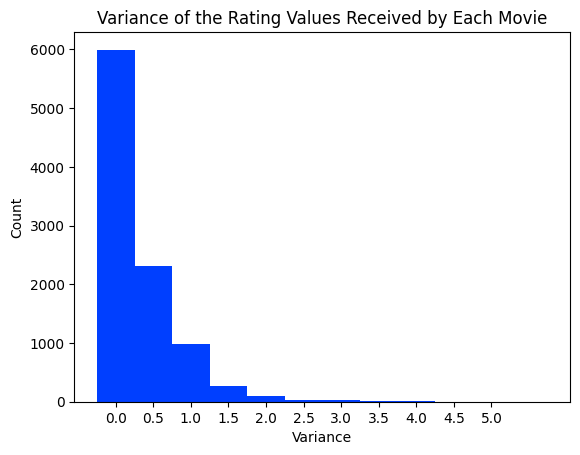

In [9]:
bins = np.arange(0, max(ratings_var) + 1, 0.5)
plt.hist(ratings_var, bins, align="left")
plt.xticks(np.arange(0, 5.5, 0.5))
plt.xlabel("Variance")
plt.ylabel("Count")
plt.title("Variance of the Rating Values Received by Each Movie")
plt.show()

### QUESTION 2: Understanding the Pearson Correlation Coefficient
#### A. Write down the formula for ${\mu_u}$ in terms of ${I_u}$ and ${r_{uk}}$
> Ans:

$$\mu_{u} = \frac{\sum_{k\in I_u} r_{uk}}{|{I_u}|}$$


#### B. In plain words, explain the meaning of ${I_u} \cap {I_v}$. Can ${I_u} \cap {I_v} = \emptyset$? 
(Hint: Rating matrix R is sparse)
> Ans: ${I_u} \cap {I_v}$ means the set of item indices for which ratings have been specified by both user u and user v. Given that the movie ratings matrix is sparse, there are chances where user u and user v"s reviews never crossed, no reviews for the same movie, so it is possible that ${I_u} \cap {I_v} = \emptyset$.

### QUESTION 3: Understanding the Prediction function
Can you explain the reason behind mean-centering the raw ratings ($r_{vj} - \mu_{v}$) in the prediction function? 
(Hint: Consider users who either rate all items highly or rate all items poorly and the impact of these users on the prediction function.)
> Ans: Mean-centering normalizes the overall data distribution, and eliminates bias caused by individual users. Some users may give ratings that are generally towards the higher or lower ends of the spectrum, and the range of the ratings given by each individual is also different. Therefore, mean-centering helps eliminate these noises and reduce the correlation between the predicting variables. Consequently, the resulting prediction function will be more robust.

### QUESTION 4: Design a k-NN collaborative filter to predict the ratings of the movies in the original dataset and evaluate its performance using 10-fold cross validation. Sweep k (number of neighbors) from 2 to 100 in step sizes of 2, and for each k compute the average RMSE and average MAE obtained by averaging the RMSE and MAE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis) and average MAE (Y-axis) against k (X-axis).

- https://piazza.com/class/lcjwqyyip6bid/post/173

In [10]:
surprise_data = Dataset.load_from_df(
    ratings_data[["userId","movieId","rating"]], Reader()
)

In [11]:
# "cross-validation folds are also randomly generated"
# https://github.com/NicolasHug/Surprise/blob/master/doc/source/FAQ.rst#how-to-have-reproducible-experiments

def knn_cv_error(k):
    knn = KNNWithMeans(
        k=k, sim_options={"name": "pearson"}, verbose=False, random_state=SEED
    )
    cv = cross_validate(
        knn, cv=10, data=surprise_data, measures=["rmse", "mae"], n_jobs=24
    )
    print(f"{k=}")
    print(f"Average RMSE = {np.mean(cv["test_rmse"])}")
    print(f"Average MAE = {np.mean(cv["test_mae"])}")
    return np.mean(cv["test_rmse"]), np.mean(cv["test_mae"])


def plot(x, y, x_label, y_label, title):
    plt.plot(x, y)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.show()

In [12]:
ks = np.arange(2, 101, 2)
rmses, maes = [], []

for k in ks:
    rmse, mae = knn_cv_error(k)
    rmses.append(rmse)
    maes.append(mae)

k=2
Average RMSE = 1.016906675847957
Average MAE = 0.7845251378212744
k=4
Average RMSE = 0.9429296378089811
Average MAE = 0.72387116736117
k=6
Average RMSE = 0.9200448908582202
Average MAE = 0.7044307201449873
k=8
Average RMSE = 0.9081321639936079
Average MAE = 0.6950334168360163
k=10
Average RMSE = 0.9013212538797394
Average MAE = 0.6887566544841593
k=12
Average RMSE = 0.8976652326027011
Average MAE = 0.6856013347085081
k=14
Average RMSE = 0.8959192029297322
Average MAE = 0.6831921408520515
k=16
Average RMSE = 0.893547489222249
Average MAE = 0.6814011008773451
k=18
Average RMSE = 0.8914196021846263
Average MAE = 0.6794789106596392
k=20
Average RMSE = 0.8898703217534484
Average MAE = 0.6785434921849103
k=22
Average RMSE = 0.890194595346205
Average MAE = 0.6780499235040827
k=24
Average RMSE = 0.8909985012316343
Average MAE = 0.6785862205980879
k=26
Average RMSE = 0.8888458745524647
Average MAE = 0.6772707618041056
k=28
Average RMSE = 0.8908372598198975
Average MAE = 0.6782915440530601
k

#### RMSE

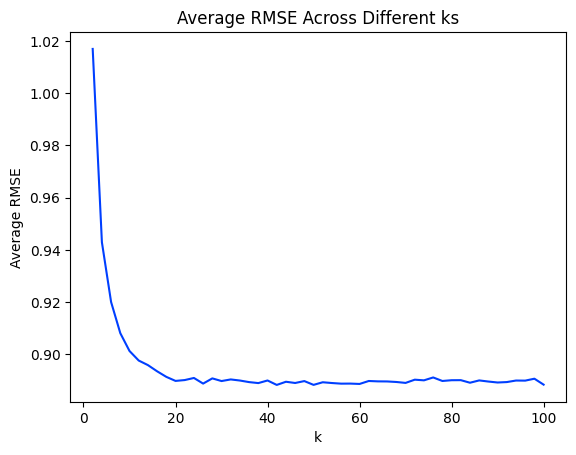

Minimum Average RMSE is: 0.8883359400134638 when k=42


In [13]:
plot(ks, rmses, "k", "Average RMSE", "Average RMSE Across Different ks")
print(f"Minimum Average RMSE is: {min(rmses)} when k={ks[min(range(len(rmses)), key=rmses.__getitem__)]}")

#### MAE

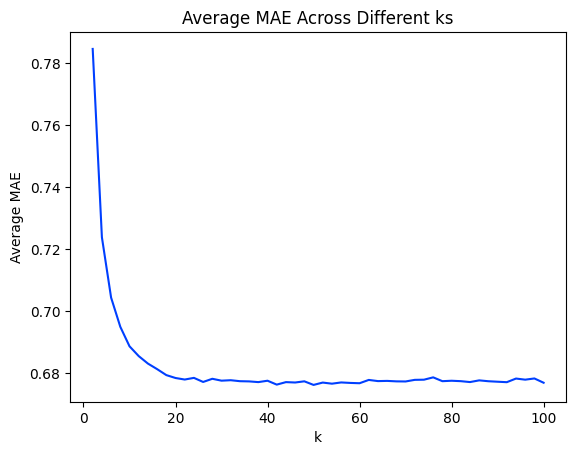

Minimum Average MAE is: 0.6763153428818235 when k=50


In [14]:
plot(ks, maes, "k", "Average MAE", "Average MAE Across Different ks")  
print(f"Minimum Average MAE is: {min(maes)} when k={ks[min(range(len(maes)), key=maes.__getitem__)]}")

### QUESTION 5: Use the plot from question 4, to find a ’minimum k’. 
Note: The term ’minimum k’ in this context means that increasing k above the minimum value would not result in a significant decrease in average RMSE or average MAE. If you get the plot correct, then ’minimum k’ would correspond to the k value for which average RMSE and average MAE converges to a steady-state value. Please report the steady state values of average RMSE and average MAE.

> Ans: From the plots above, both curves from RMSE and MAE reach a steady state at k=20. Beyond this point, the average RMSE and MAE no longer decrease significantly. Seeking proof from the resulting data, at k=20, RMSE=0.890194595346205 and MAE=0.6780499235040827, and both numbers only fluctuate slightly onward.

- https://piazza.com/class/lcjwqyyip6bid/post/171

### QUESTION 6: Within EACH of the 3 trimmed subsets in the dataset, design: A k-NN collaborative filter to predict the ratings of the movies (i.e Popular, Unpopular or High-Variance) and evaluate each of the three models’ performance using 10-fold cross validation:

• Sweep k (number of neighbors) from 2 to 100 in step sizes of 2, and for each k compute the average RMSE obtained by averaging the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis). Also, report the minimum average RMSE. <br>

- https://piazza.com/class/lcjwqyyip6bid/post/172
- https://piazza.com/class/lcjwqyyip6bid/post/170
- https://piazza.com/class/lcjwqyyip6bid/post/168
- https://piazza.com/class/lcjwqyyip6bid/post/166


Notes:
- BTW, I just tried to run my code when given the trimmed trainset, and I find the average rmse doen"t change when k increases. The plot is a line. It seems like something"s wrong.
- Perhaps it"s because the numbers of samples in unpopular and high variance subsets are too small - yes, this is the point. The popular trimming should work out fine.



In [16]:
def prepare_dataset():

    freq_dict = ratings_data["movieId"].value_counts().to_dict()
    var_dict = dict(zip(movie_ID_unique, ratings_var))

    needed_cols = ["userId","movieId","rating"]
    popular_cond = lambda x: freq_dict[x] > 2
    unpopular_cond = lambda x: freq_dict[x] <= 2
    high_variance_cond = lambda x: freq_dict[x] > 5 and var_dict[x] >=2 
    
    popular_data = Dataset.load_from_df(
        ratings_data[ratings_data.movieId.apply(popular_cond)][needed_cols], Reader()
    )
    unpopular_data = Dataset.load_from_df(
        ratings_data[ratings_data.movieId.apply(unpopular_cond)][needed_cols], Reader()
    )
    high_variance_data = Dataset.load_from_df(
        ratings_data[ratings_data.movieId.apply(high_variance_cond)][needed_cols], Reader()
    )
    
    return popular_data, unpopular_data, high_variance_data

In [17]:
nested_dict = lambda: defaultdict(nested_dict)
res_dict = nested_dict()

def knn_nmf_mfb_pipeline(trim_type, method, ks, verbose=False):
    rmses = []
    
    for k in tqdm(ks):
        if method == "knn":
            model = KNNWithMeans(
                k=k, sim_options={"name": "pearson"}, verbose=False, random_state=SEED
            )
        elif method == "nmf":
            model = NMF(n_factors=k, random_state=SEED)
        elif method == "mfb":
            model = SVD(n_factors=k, random_state=SEED)
            
        rmse = []
        for train, test in KFold(
            n_splits=10, random_state=SEED
        ).split(trim_dataset[trim_type]):
            pred = model.fit(train).test(test)
            rmse_error = accuracy.rmse(pred, verbose=False)
            rmse.append(rmse_error)
            res_dict[trim_type][method][k]["prediction"] = pred
            res_dict[trim_type][method][k]["test"] = test
            res_dict[trim_type][method][k]["rmse"] = rmse_error
        rmses.append(np.mean(rmse))    

        if verbose:
            print(f"{k=}")
            print(f"Average RMSE = {rmses[-1]}")
        
    plot(ks, rmses, "k", "Average RMSE", "Average RMSE Across Different ks")
    print(f"Minimum Average RMSE is: {min(rmses)}")

In [18]:
popular_data, unpopular_data, hign_variance_data = prepare_dataset()
trim_dataset = {"no_trim": surprise_data,
                "popular": popular_data,
                "unpopular": unpopular_data, 
                "high_variance": hign_variance_data}

#### Popular Movie Trimming

  0%|          | 0/50 [00:00<?, ?it/s]

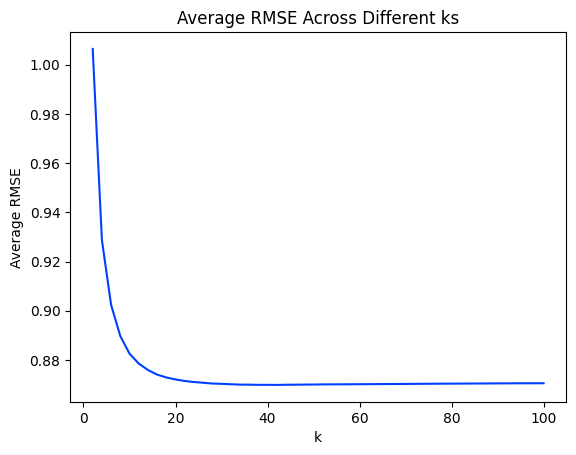

Minimum Average RMSE is: 0.8698435928728039


In [19]:
knn_nmf_mfb_pipeline("popular", "knn", ks)

#### Unpopular Movie Trimming

  0%|          | 0/50 [00:00<?, ?it/s]

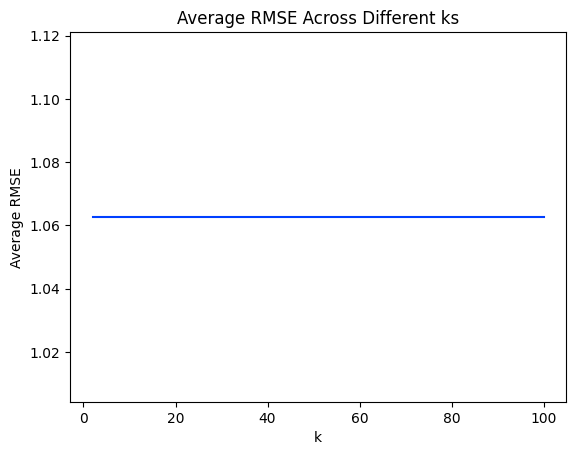

Minimum Average RMSE is: 1.0626739049330767


In [20]:
knn_nmf_mfb_pipeline("unpopular", "knn", ks)

#### High Variance Movie Trimming

  0%|          | 0/50 [00:00<?, ?it/s]

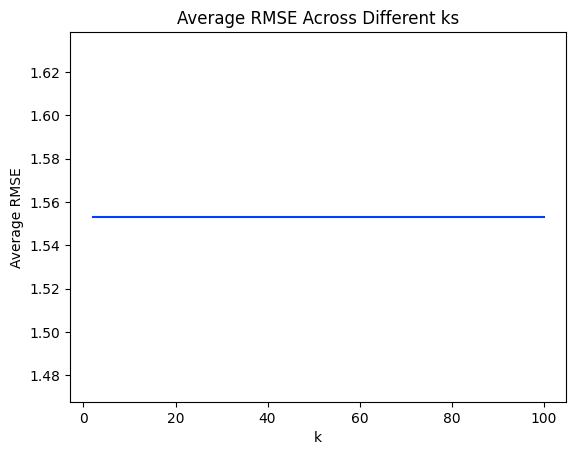

Minimum Average RMSE is: 1.553110074395001


In [21]:
knn_nmf_mfb_pipeline("high_variance", "knn", ks)

• Plot the ROC curves for the k-NN collaborative filters for threshold values [2.5, 3, 3.5, 4]. These thresholds are applied only on the training set. For each of the plots, also report the area under the curve (AUC) value. You should have 4 × 4 plots in this section (4 trimming options – including no trimming times 4 thresholds) - all thresholds can be condensed into one plot per trimming option yielding only 4 plots.

- https://piazza.com/class/lcjwqyyip6bid/post/174
- https://piazza.com/class/lcjwqyyip6bid/post/169

In [22]:
def plot_roc_curves_by_method(method, data):
    train_split, test_split = train_test_split(data, test_size=0.1, random_state=SEED)

    if method == "knn":
        model = KNNWithMeans(
            k=20, sim_options={"name": "pearson"}, verbose=False, random_state=SEED
        ).fit(train_split)
    elif method == "nmf":
        model = NMF(n_factors=num_of_genres, random_state=SEED).fit(train_split)
    elif method == "mfb":
        model = SVD(n_factors=optimal_latent_factor, random_state=SEED).fit(train_split)
    else:
        raise ValueError(f"Method {method} not supported.")

    y_test = [y[2] for y in test_split]
    y_pred = [x.est for x in model.test(test_split)]

    thresholds = [2.5, 3.0, 3.5, 4.0]
    plot_roc_curves(y_test, y_pred, thresholds)

In [23]:
def plot_roc_curves(y_test, y_pred, thresholds):
    for t in thresholds:
        y_true = [int(y >= t) for y in y_test]
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        auc = roc_auc_score(y_true, y_pred)
        plt.plot(fpr, tpr, label = "Threshold: %.1f, AUC: %.4f" %(t, auc))   
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.plot([0, 1], [0, 1], ls="--")
    plt.legend(loc="lower right")
    plt.title("ROC Curves")
    plt.show()

#### No Trimming

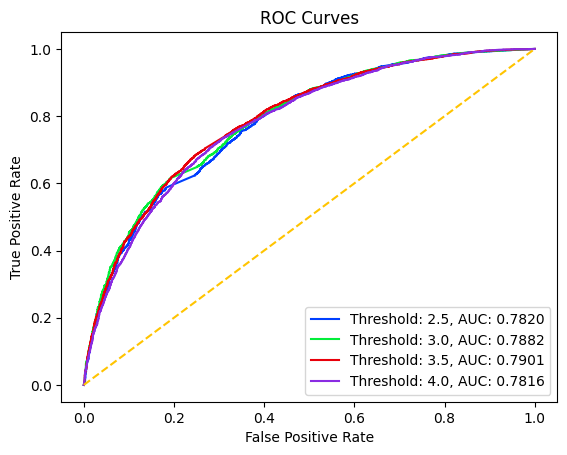

In [24]:
plot_roc_curves_by_method("knn", trim_dataset["no_trim"])

#### Popular Movie Trimming

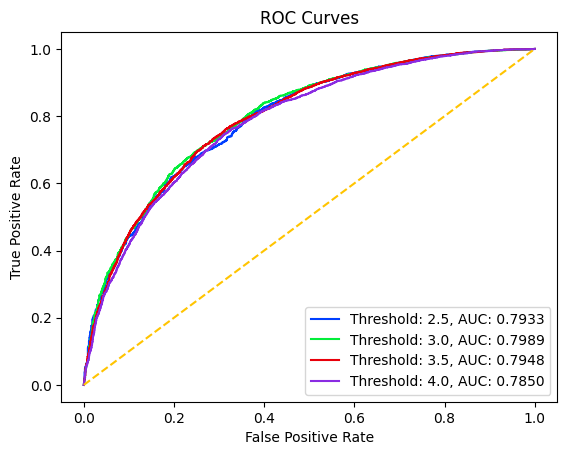

In [25]:
plot_roc_curves_by_method("knn", trim_dataset["popular"])

#### Unpopular Movie Trimming

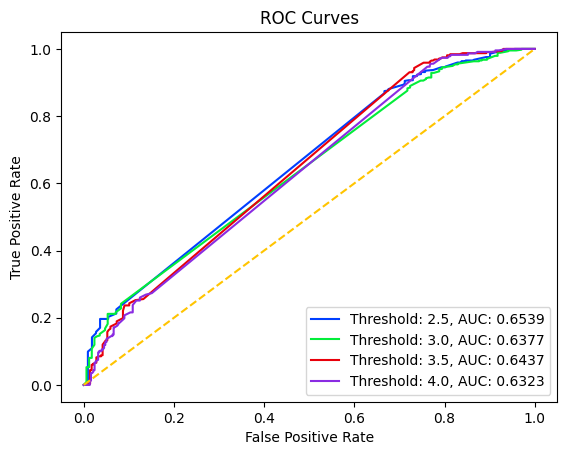

In [26]:
plot_roc_curves_by_method("knn", trim_dataset["unpopular"])

#### High Variance Movie Trimming

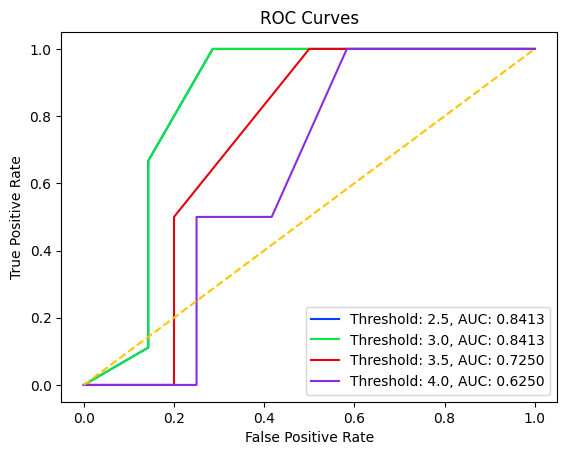

In [27]:
plot_roc_curves_by_method("knn", trim_dataset["high_variance"])

### QUESTION 7: Understanding the NMF cost function
Is the optimization problem given by equation 5 convex? Consider the optimization problem given by equation 5. For U fixed, formulate it as a least-squares problem.
> Ans:  No, it is not convex. The optimization problem for finding optimal user latent space, U, and item embedding space, V in a matrix factorization model is not jointly convex due to the presence of multiple local minima in the gradient plane of the objective function. This is because the model predicts ratings by taking the product of U and V, which violates the convexity property. Specifically, the objective function is not invariant to permutations and rotations, leading to non-convexity.

> One approach is to use the alternating least-squares method, which alternates between updating user latent space U while keeping item embedding space V fixed and updating V while keeping U fixed. Specifically, when U is fixed, the least-squares formulation of the objective function is given by:


<center>
$\begin{align} \min_{v} \sum_{i=1}^{m}\sum_{j=1}^{n}W_{ij}(r_{ij} - (UV^T)_{ij}))^2 \end{align}$
    <br>
where $V = (UU^T + \lambda I)^{-1}UR$, $\lambda I$ = regularization term and $R$ = rating matrix


> Reference to: https://www.quora.com/What-is-the-Alternating-Least-Squares-method-in-recommendation-systems-And-why-does-this-algorithm-work-intuition-behind-this

### QUESTION 8: Designing the NMF Collaborative Filter
#### A. Design a NMF-based collaborative filter to predict the ratings of the movies in the original dataset and evaluate its performance using 10-fold cross-validation. 
Sweep k (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE and average MAE obtained by averaging the RMSE and MAE across all 10 folds. If NMF takes too long, you can increase the step size. Increasing it too much will result in poorer granularity in your results. Plot the average RMSE (Y-axis) against k (X-axis) and the average MAE (Yaxis) against k (X-axis). For solving this question, use the default value for the regularization
parameter.

In [28]:
ks = np.arange(2, 51, 2)

def nmf_cv_error(k):
    nmf = NMF(n_factors=k, random_state=SEED)
    cv = cross_validate(nmf, surprise_data, cv=10, n_jobs=24)
    
    print(f"{k=}")
    print(f"RMSE = {np.mean(cv["test_rmse"])}")
    print(f"MAE = {np.mean(cv["test_mae"])}")
    return np.mean(cv["test_rmse"]), np.mean(cv["test_mae"])

In [29]:
rmses, maes = [], []
for k in ks:
    rmse, mae = nmf_cv_error(k)
    rmses.append(rmse)
    maes.append(mae)

k=2
RMSE = 1.1419237783038532
MAE = 0.9606237958675257
k=4
RMSE = 1.0405397811819432
MAE = 0.8503250417558752
k=6
RMSE = 0.981385389066471
MAE = 0.7857090982922956
k=8
RMSE = 0.9497151691557593
MAE = 0.7494137226539104
k=10
RMSE = 0.931216194251621
MAE = 0.7252502589208876
k=12
RMSE = 0.9190728064796779
MAE = 0.70961049487742
k=14
RMSE = 0.9140498361939488
MAE = 0.702117702511349
k=16
RMSE = 0.9107404420493872
MAE = 0.6962677334811503
k=18
RMSE = 0.9109657867681464
MAE = 0.6941650065625149
k=20
RMSE = 0.9130534140810734
MAE = 0.6929698205412457
k=22
RMSE = 0.9163636038817737
MAE = 0.6932196258652465
k=24
RMSE = 0.9165638686895108
MAE = 0.6935883124753867
k=26
RMSE = 0.9204038693419735
MAE = 0.6952045300444402
k=28
RMSE = 0.9272494519469854
MAE = 0.700292994516668
k=30
RMSE = 0.9301130331813218
MAE = 0.701349886936866
k=32
RMSE = 0.9316315163235493
MAE = 0.7024930777431037
k=34
RMSE = 0.9387006772433184
MAE = 0.7078074419177595
k=36
RMSE = 0.9386452866510687
MAE = 0.7073969922329632
k=3

#### RMSE

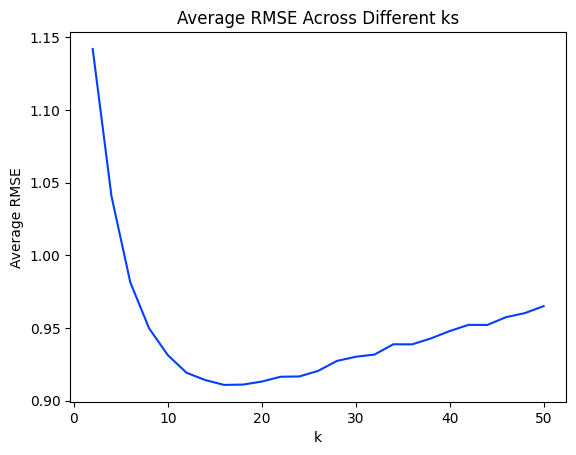

Minimum Average RMSE is: 0.9107404420493872 when k=16


In [30]:
plot(ks, rmses, "k", "Average RMSE", "Average RMSE Across Different ks")  
print(f"Minimum Average RMSE is: {min(rmses)} when k={ks[min(range(len(rmses)), key=rmses.__getitem__)]}")

#### MAE

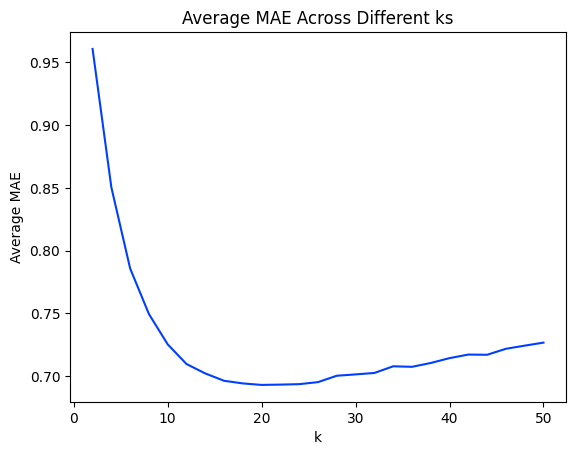

Minimum Average MAE is: 0.6929698205412457 when k=20


In [31]:
plot(ks, maes, "k", "Average MAE", "Average MAE Across Different ks") 
print(f"Minimum Average MAE is: {min(maes)} when k={ks[min(range(len(maes)), key=maes.__getitem__)]}")

#### B. Use the plot from the previous part to find the optimal number of latent factors. 
Optimal number of latent factors is the value of k that gives the minimum average RMSE or the minimum average MAE. Please report the minimum average RMSE and MAE. Is the optimal number of latent factors same as the number of movie genres?

- https://piazza.com/class/lcjwqyyip6bid/post/180

> Ans: The latent factor from RMSE is 16, rendering minimum average RMSE = 0.9107404420493872; the latent factor for MAE is 20, rendering minimum average MAE = 0.6929698205412457. Even though the total number of movie genres is 19 and is not the same as either of the latent factors from RMSE and MAE, they are very close. In addition, we noticed that the number of movie genres is in between these two latent factors.

In [33]:
genres = " ".join(movies_data["genres"]).replace("|"," ").replace("(no genres listed)","").split(" ")

In [34]:
set(genres)  # not sure about IMAX -> update: IMAX count

{'',
 'Action',
 'Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'IMAX',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western'}

In [35]:
num_of_genres = len(set(genres))-1  # -1 since there is empty after processing

In [36]:
print(f"Number of movie genres: {num_of_genres}")

Number of movie genres: 19


#### C. Performance on trimmed dataset subsets: For each of Popular, Unpopular and High-Variance subsets -
– Design a NMF collaborative filter to predict the ratings of the movies in the trimmed subset and evaluate its performance using 10-fold cross validation. Sweep k (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE obtained by averaging the RMSE across all 10 folds. <br>
– Plot average RMSE (Y-axis) against k (X-axis); item Report the minimum average RMSE.

#### Popular Movie Trimming

  0%|          | 0/25 [00:00<?, ?it/s]

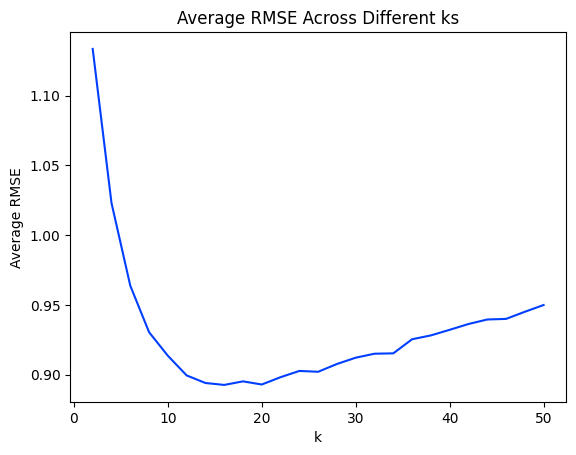

Minimum Average RMSE is: 0.8925807026573258


In [37]:
knn_nmf_mfb_pipeline("popular", "nmf", ks)

#### Unpopular Movie Trimming

  0%|          | 0/25 [00:00<?, ?it/s]

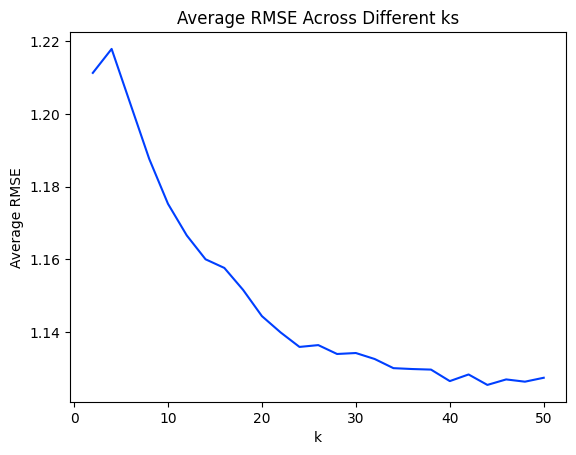

Minimum Average RMSE is: 1.1254893283725884


In [38]:
knn_nmf_mfb_pipeline("unpopular", "nmf", ks)

#### High Variance Movie Trimming

  0%|          | 0/25 [00:00<?, ?it/s]

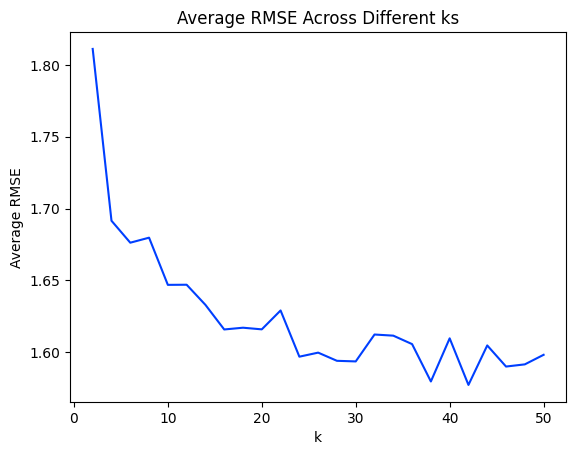

Minimum Average RMSE is: 1.5770557861342742


In [39]:
knn_nmf_mfb_pipeline("high_variance", "nmf", ks)

+ Plot the ROC curves for the NMF-based collaborative filter and also report the area under the curve (AUC) value as done in Question 6. 

#### No Trimming

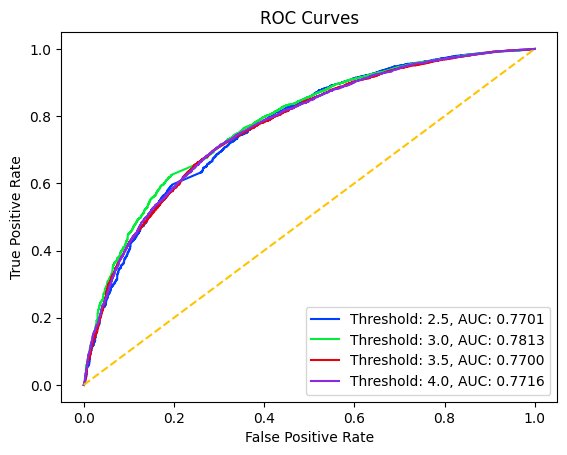

In [40]:
plot_roc_curves_by_method("nmf", trim_dataset["no_trim"])

#### Popular Movie Trimming

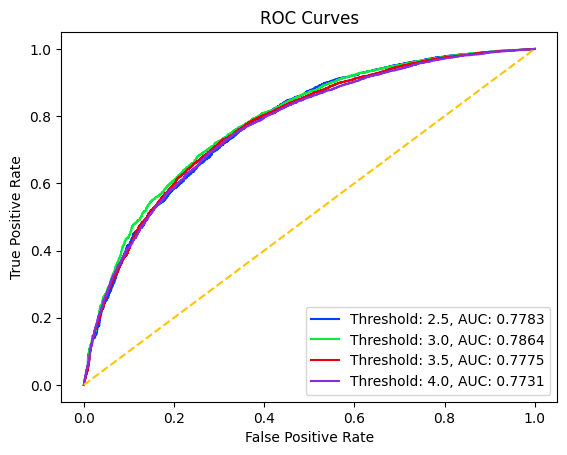

In [41]:
plot_roc_curves_by_method("nmf", trim_dataset["popular"])

#### Unpopular Movie Trimming

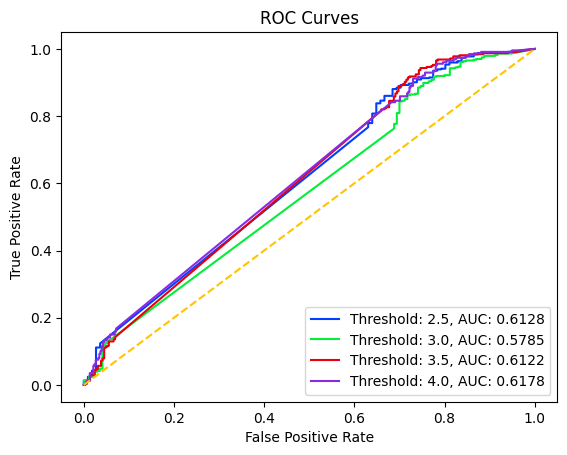

In [42]:
plot_roc_curves_by_method("nmf", trim_dataset["unpopular"])

#### High Variance Movie Trimming

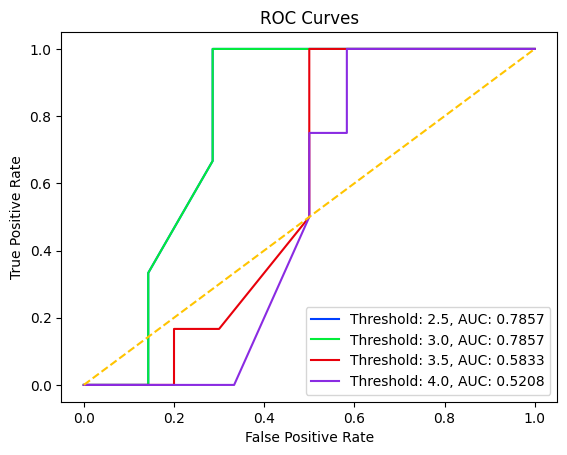

In [43]:
plot_roc_curves_by_method("nmf", trim_dataset["high_variance"])

### QUESTION 9: Interpreting the NMF model
Perform Non-negative matrix factorization on the ratings matrix R to obtain the factor matrices U and V , where U represents the user-latent factors interaction and V represents the movie-latent factors interaction (use k = 20). For each
column of V , sort the movies in descending order and report the genres of the top 10 movies. Do the top 10 movies belong to a particular or a small collection of genre? Is there a connection between the latent factors and the movie genres?
> Ans: From the results, we can see that for each latent factor, the top ten movie genres comprise of certain types of movies. For example, latent factor 1 mainly contains drama; latent factor 10 mainly contains action and adventure, etc. The latent factors tend to aggregate movies of the same genre.

In [44]:
nmf = NMF(n_factors=20, random_state=SEED).fit(surprise_data.build_full_trainset())
U = nmf.pu
V = nmf.qi

for i in range(20):
    movie_idxs = V[:,i].argsort()[::-1][0:10]
    
    print(f"Latent Factor: {i+1}")
    print("-------------------------------------------")
    print("Top 10 Movie Genres:")
    
    for idx, mid in enumerate(movie_idxs):
        print(f"{idx+1}. {movies_data.iloc[mid]["genres"]}")
    print("===========================================")

Latent Factor: 1
-------------------------------------------
Top 10 Movie Genres:
1. Action|Adventure|Crime|Thriller
2. Documentary
3. Crime|Thriller|War
4. Comedy|Drama
5. Mystery
6. Comedy|Crime
7. Crime|Mystery|Thriller
8. Action|Adventure|Fantasy|Horror
9. Drama|Romance
10. Drama
Latent Factor: 2
-------------------------------------------
Top 10 Movie Genres:
1. Children|Fantasy|Musical
2. Adventure|Animation|Children|Comedy
3. Comedy|Drama
4. Action|Animation|Fantasy|Sci-Fi
5. Crime|Drama|Mystery|Thriller
6. Comedy|Fantasy
7. Horror|Mystery|Thriller
8. Drama|Romance|War
9. Comedy|Drama
10. Children|Comedy
Latent Factor: 3
-------------------------------------------
Top 10 Movie Genres:
1. Action|Adventure|Drama|Romance
2. Documentary
3. Drama
4. Drama
5. Drama|Romance|Sci-Fi
6. Action|Sci-Fi|Thriller
7. Comedy|Crime
8. Documentary
9. Drama|War
10. Comedy|Thriller
Latent Factor: 4
-------------------------------------------
Top 10 Movie Genres:
1. Action|Sci-Fi
2. Action|Drama|Thr

### QUESTION 10: Designing the MF Collaborative Filter
#### A. Design a MF-based collaborative filter to predict the ratings of the movies in the original dataset and evaluate it’s performance using 10-fold cross-validation. 
Sweep k (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE and average MAE obtained by averaging the RMSE and MAE across all 10 folds. Plot the average RMSE (Y-axis) against k (X-axis) and the average MAE (Y-axis) against k (X-axis). For solving this question, use the default value for the regularization parameter.

In [45]:
def mfb_cv_error(k):
    mfb = SVD(n_factors=k, random_state=SEED)
    cv = cross_validate(mfb, surprise_data, cv=10, n_jobs=24)
    print(f"{k=}")
    print(f"RMSE = {np.mean(cv["test_rmse"])}")
    print(f"MAE = {np.mean(cv["test_mae"])}")
    return np.mean(cv["test_rmse"]), np.mean(cv["test_mae"])

rmses, maes = [], []
for k in ks:
    rmse, mae = mfb_cv_error(k)
    rmses.append(rmse)
    maes.append(mae)

k=2
RMSE = 0.8673627750939957
MAE = 0.6666052880309481
k=4
RMSE = 0.8676709491793932
MAE = 0.6667073220136052
k=6
RMSE = 0.8658091121226412
MAE = 0.6647032451880788
k=8
RMSE = 0.8665480648396766
MAE = 0.6657405821572364
k=10
RMSE = 0.8657046465065198
MAE = 0.6650296633443971
k=12
RMSE = 0.8670958999486569
MAE = 0.6661347233261103
k=14
RMSE = 0.8664153274133805
MAE = 0.6656623910077883
k=16
RMSE = 0.8648768306072961
MAE = 0.6639167879342188
k=18
RMSE = 0.8661118443476212
MAE = 0.6650253050185908
k=20
RMSE = 0.866085101559871
MAE = 0.6653792508474892
k=22
RMSE = 0.8649252988588924
MAE = 0.6641050740943019
k=24
RMSE = 0.8643469351342568
MAE = 0.6635176621755533
k=26
RMSE = 0.8672255204043035
MAE = 0.6655476455592053
k=28
RMSE = 0.8645583158005751
MAE = 0.663971021722084
k=30
RMSE = 0.8648266223302106
MAE = 0.6638157051678322
k=32
RMSE = 0.8649328162290159
MAE = 0.6642007068082746
k=34
RMSE = 0.8661644633421837
MAE = 0.6649503816686727
k=36
RMSE = 0.8661059285449781
MAE = 0.665176136135224

#### RMSE

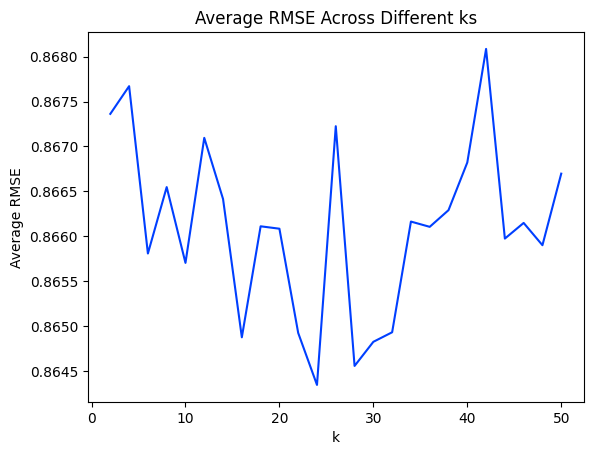

Minimum Average RMSE is: 0.8643469351342568 when k=24


In [46]:
plot(ks, rmses, "k", "Average RMSE", "Average RMSE Across Different ks")  
print(f"Minimum Average RMSE is: {min(rmses)} when k={ks[min(range(len(rmses)), key=rmses.__getitem__)]}")

#### MAE

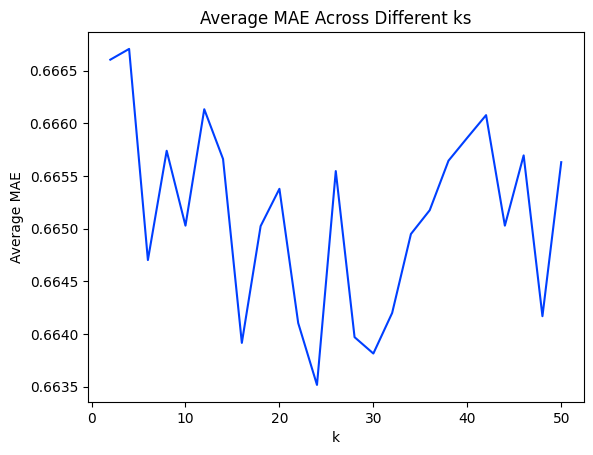

Minimum Average MAE is: 0.6635176621755533 when k=24


In [47]:
plot(ks, maes, "k", "Average MAE", "Average MAE Across Different ks") 
print(f"Minimum Average MAE is: {min(maes)} when k={ks[min(range(len(maes)), key=maes.__getitem__)]}")

#### B. Use the plot from the previous part to find the optimal number of latent factors. 
Optimal number of latent factors is the value of k that gives the minimum average RMSE or the minimum average MAE. Please report the minimum average RMSE and MAE. Is the optimal number of latent factors same as the number of movie genres?

> Ans: For both RMSE and MAE, we get the optimal latent factor 24 and 24. The minimum average RMSE is 0.8643469351342568 and the minimum average MAE = 0.6635176621755533. The total number of movie genres is 19, which is not close to what we get from our results.

#### C. Performance on dataset subsets: For each of Popular, Unpopular and High-Variance subsets-
– Design a MF collaborative filter to predict the ratings of the movies in the trimmed subset and evaluate its performance using 10-fold cross validation. Sweep k (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE obtained by averaging the RMSE across all 10 folds. <br>
– Plot average RMSE (Y-axis) against k (X-axis); item Report the minimum average RMSE.

#### Popular Movie Trimming

  0%|          | 0/25 [00:00<?, ?it/s]

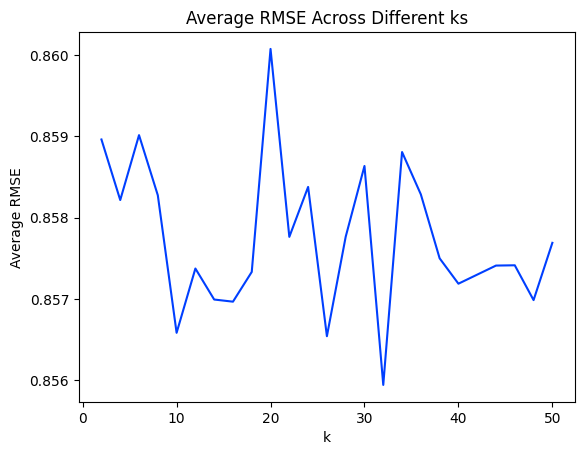

Minimum Average RMSE is: 0.8559425681174059


In [49]:
knn_nmf_mfb_pipeline("popular", "mfb", ks)

#### Unpopular Movie Trimming

  0%|          | 0/25 [00:00<?, ?it/s]

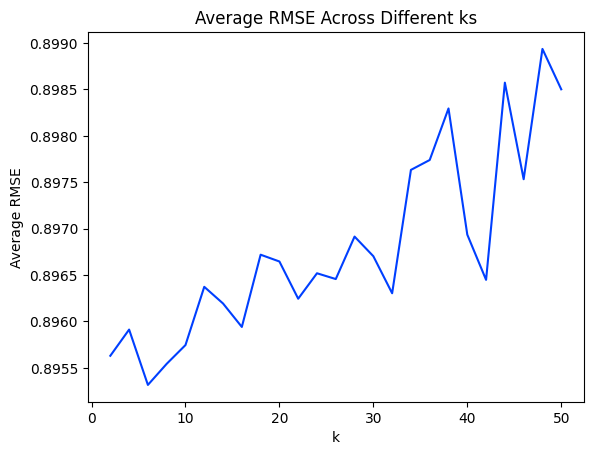

Minimum Average RMSE is: 0.895315750447795


In [50]:
knn_nmf_mfb_pipeline("unpopular", "mfb", ks)

#### High Variance Movie Trimming

  0%|          | 0/25 [00:00<?, ?it/s]

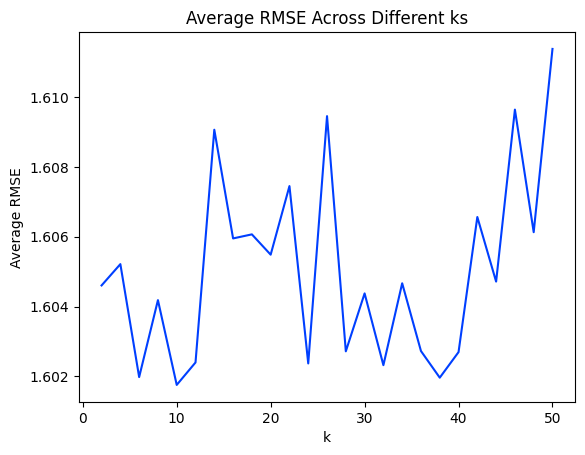

Minimum Average RMSE is: 1.6017562372924512


In [51]:
knn_nmf_mfb_pipeline("high_variance", "mfb", ks)

• Plot the ROC curves for the MF-based collaborative filter and also report the area under the curve (AUC) value as done in Question 6.

In [52]:
optimal_latent_factor = 12

#### No Trimming

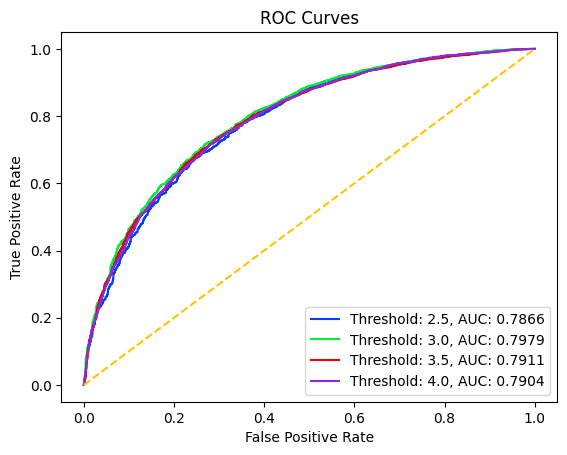

In [53]:
plot_roc_curves_by_method("mfb", trim_dataset["no_trim"])

#### Popular Movie Trimming

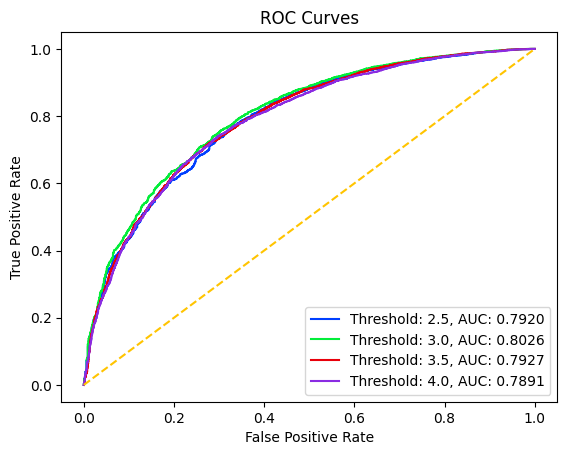

In [54]:
plot_roc_curves_by_method("mfb", trim_dataset["popular"])

#### Unpopular Movie Trimming

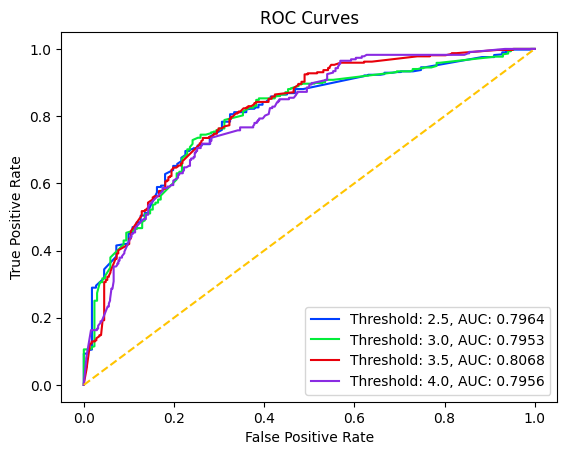

In [55]:
plot_roc_curves_by_method("mfb", trim_dataset["unpopular"])

#### High Vairance Movie Trimming

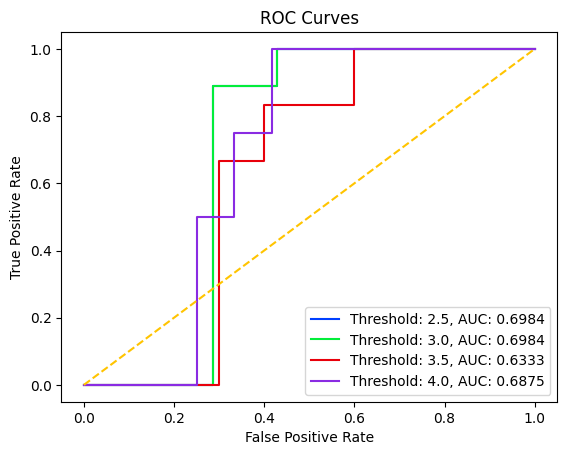

In [56]:
plot_roc_curves_by_method("mfb", trim_dataset["high_variance"])

### QUESTION 11: Designing a Na¨ıve Collaborative Filter
#### Design a naive collaborative filter to predict the ratings of the movies in the original dataset and evaluate its performance using 10-fold cross validation. Compute the average RMSE by averaging the RMSE across all 10 folds. Report the average RMSE.

In [57]:
mean_ratings_dict = ratings_data.groupby(["userId"]).mean()["rating"].to_dict()

rmse = []
for train, test in KFold(n_splits=10, random_state=SEED).split(surprise_data):
    true = [n[2] for n in test]
    pred = [mean_ratings_dict[n[0]] for n in test]
    rmse.append(mean_squared_error(true, pred, squared=False))
print("Average RMSE:", np.mean(rmse))

Average RMSE: 0.9346989112936062


#### Performance on dataset subsets
For each of Popular, Unpopular and High-Variance test subsets-<br>
– Design a naive collaborative filter to predict the ratings of the movies in each trimmed set and evaluate its performance using 10-fold cross validation. <br>
– Compute the average RMSE by averaging the RMSE across all 10 folds. Report the average RMSE.

In [58]:
def naive_pipeline(trim_type):
    needed_cols = ["userId","movieId","rating"]
    rmses = []
    
    for train, test in KFold(
        n_splits=10, random_state=SEED
    ).split(trim_dataset[trim_type]):
        test_df = pd.DataFrame(test, columns=needed_cols)
        mean_ratings_dict = test_df.groupby(["userId"]).mean()["rating"].to_dict()

        true = [n[2] for n in test]
        pred = [mean_ratings_dict[n[0]] for n in test]
        rmses.append(mean_squared_error(true, pred, squared=False))
        
    print(f"Average RMSE: {np.mean(rmses)}")

#### Popular Movie Trimming

In [59]:
naive_pipeline("popular")

Average RMSE: 0.9032151629734988


#### Unpopular Movie Trimming

In [60]:
naive_pipeline("unpopular")

Average RMSE: 0.7437484897529769


#### High Variance Trimming

In [61]:
naive_pipeline("high_variance")

Average RMSE: 0.18391799447340687


### QUESTION 12: Comparing the most performant models across architecture
Plot the best ROC curves (threshold = 3) for the k-NN, NMF, and MF with bias based collaborative filters in the same figure. Use the figure to compare the performance of the filters in predicting the ratings of the movies.
> Ans: MF with bias has the largest area under the curve, which means that MF with bias is the best model among the three filters.

  0%|          | 0/8 [00:00<?, ?it/s]

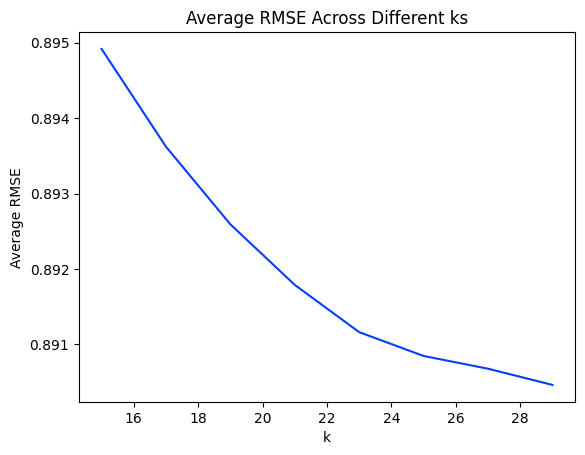

Minimum Average RMSE is: 0.8904633863602127


  0%|          | 0/8 [00:00<?, ?it/s]

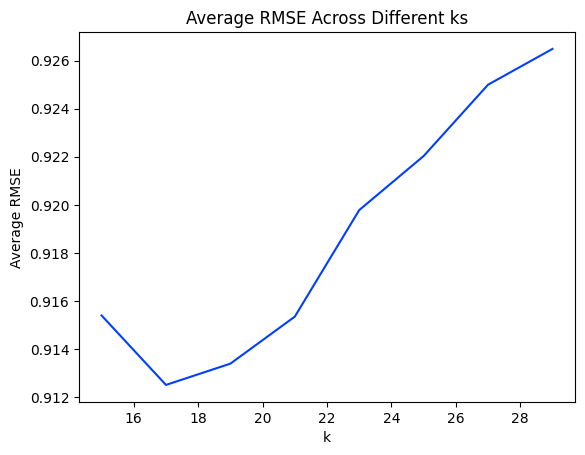

Minimum Average RMSE is: 0.9125100480087125


  0%|          | 0/8 [00:00<?, ?it/s]

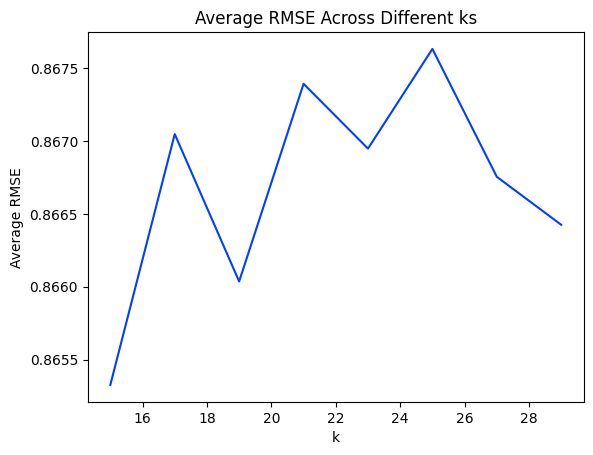

Minimum Average RMSE is: 0.865325710044696


In [62]:
ks = np.arange(15, 30, 2)

knn_nmf_mfb_pipeline("no_trim", "knn", ks)
knn_nmf_mfb_pipeline("no_trim", "nmf", ks)
knn_nmf_mfb_pipeline("no_trim", "mfb", ks)

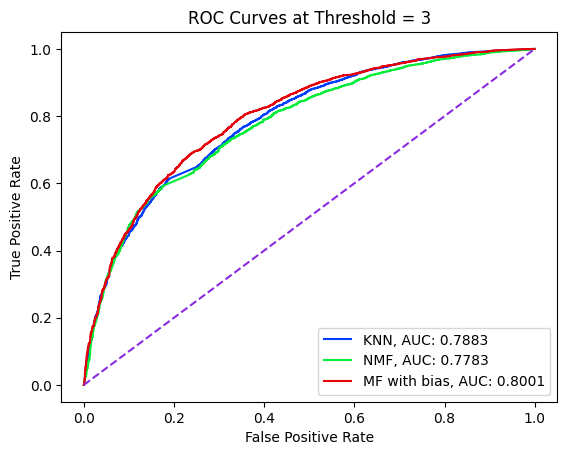

In [64]:
true_and_preds = [res_dict["no_trim"]["knn"][29], 
                  res_dict["no_trim"]["nmf"][17], 
                  res_dict["no_trim"]["mfb"][15]]

method_names = ["KNN", "NMF", "MF with bias"]

for true_and_pred, method in zip(true_and_preds, method_names):
    y_true, y_pred = [], []
    for i in range(len(true_and_pred["test"])):
        y_true.append(1 if (true_and_pred["test"][i][2] >= 3) else 0)
        y_pred.append(true_and_pred["prediction"][i].est)
        
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    plt.plot(fpr, tpr, label = "%s, AUC: %.4f" %(method, auc))
    
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot([0,1], [0,1], ls="--")
plt.legend(loc="lower right")
plt.title("ROC Curves at Threshold = 3")
plt.show()

### QUESTION 13: Understanding Precision and Recall in the context of Recommender Systems
Precision and Recall are defined by the mathematical expressions given by equations 12 and 13 respectively. Please explain the meaning of precision and recall in your own words.
> Ans: Precision from equation 12 means the portion of the set of t recommended items that overlaps with the set of items liked by the user. It tells us how many recommended results are relevent. <br>
Recall from quation 13 means the fraction of the set of items liked by the user that overlaps with the set of t recommended items. It shows how many relevent recommedations are given.

### QUESTION 14: Comparing the precision-recall metrics for the different models
#### • For each of the three architectures: <br>
– Plot average precision (Y-axis) against t (X-axis) for the ranking obtained using the model’s predictions. <br>
– Plot the average recall (Y-axis) against t (X-axis) and plot the average precision (Y-axis) against average recall (X-axis). <br>
– Use the best k found in the previous parts and sweep t from 1 to 25 in step sizes of 1. For each plot, briefly comment on the shape of the plot.
> Ans: As we can see in the figures below, precision decreases while recall increases as t increases for all three precision-recall curves.

In [65]:
ts = np.arange(1, 26)


def calc_precision_recall(method, ts, verbose=False):
    precisions, recalls = [], []
    for t in tqdm(ts):
        precision_set, recall_set = [], []
        for train, test in KFold(n_splits=10, random_state=SEED).split(surprise_data):           
            G, trimmed_test = drop_user(test, t)
            
            if method == "knn":
                model = KNNWithMeans(
                    k=20, sim_options={"name":"pearson"}, verbose=False, random_state=SEED
                )
                pred = model.fit(train).test(trimmed_test)
            elif method == "nmf":
                model = NMF(n_factors=19, random_state=SEED)
                pred = model.fit(train).test(trimmed_test)
            elif method == "mfb":
                model = SVD(n_factors=32, random_state=SEED)
                pred = model.fit(train).test(trimmed_test)
            
            estimate_rating = {}
            for user, item, rating, est, _ in pred:
                if user not in estimate_rating.keys():
                    estimate_rating[user] = []
                estimate_rating[user].append((item, est))
                
            user_precision, user_recall = [], []
            for i in estimate_rating.keys():
                s = sorted(estimate_rating[i], key=lambda x: x[1], reverse=True)
                st = set([j[0] for j in s[0:t]])
                user_precision.append(len(st.intersection(G[i]))/(len(st)))
                user_recall.append(len(st.intersection(G[i]))/(len(G[i])))
                
            precision_set.append(np.mean(user_precision))
            recall_set.append(np.mean(user_recall))
            
        precisions.append(np.mean(precision_set))
        recalls.append(np.mean(recall_set))
        if verbose:
            print(f"t = {t}; precision = {np.mean(precision_set)}; recall = {np.mean(recall_set)}")
    plot(ts, precisions, "t", "Precision", "Average Precision Across ts")
    plot(ts, recalls, "t", "Recall", "Average Recall Across ts")
    plot(recalls, precisions, "Recall", "Precision", "Average Precision vs. Average Recall")
    return precisions, recalls


def drop_user(testset, t):
    ratings, G = {}, {}
    test_trimmed = []
    for user, item, rating in testset:
        if user not in G.keys():
            G[user] = set()
        if rating >= 3:
            G[user].add(item)
        if user not in ratings.keys():
            ratings[user] = []
        ratings[user].append(item)
    for i in testset:
        user = i[0]
        if len(ratings[user]) >= t and len(G[user]) > 0:
            test_trimmed.append(i)         
    return G, test_trimmed

##### KNN

  0%|          | 0/25 [00:00<?, ?it/s]

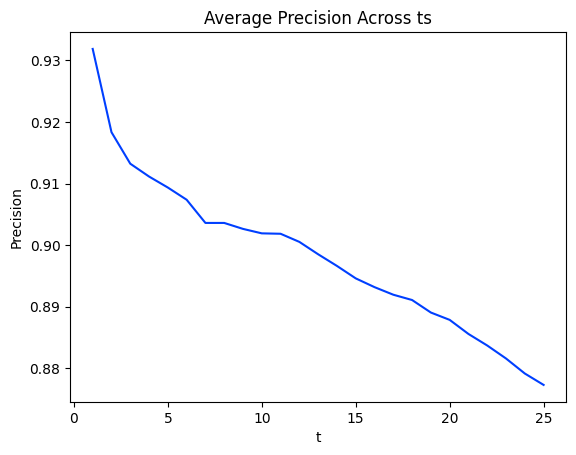

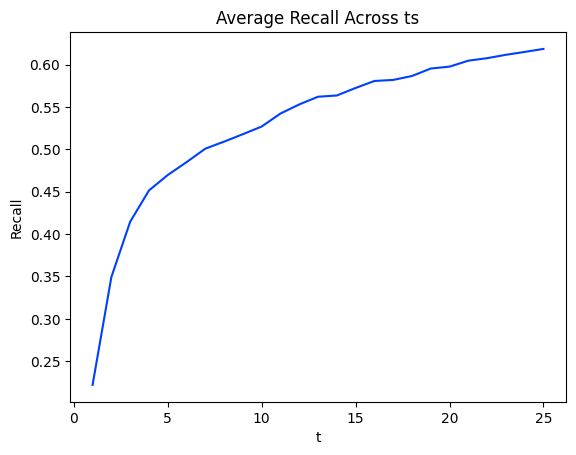

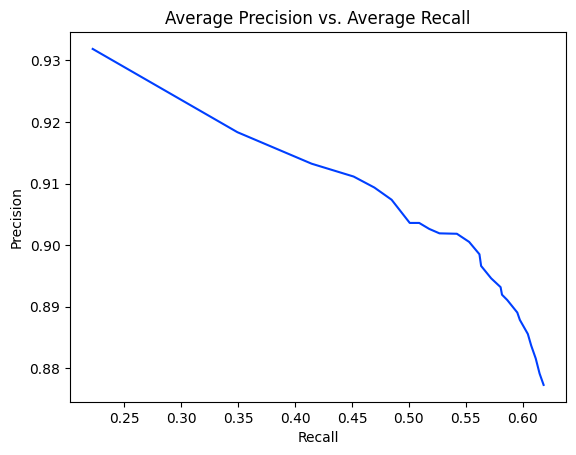

In [66]:
knn_precisions, knn_recalls = calc_precision_recall("knn", ts)

##### NMF

  0%|          | 0/25 [00:00<?, ?it/s]

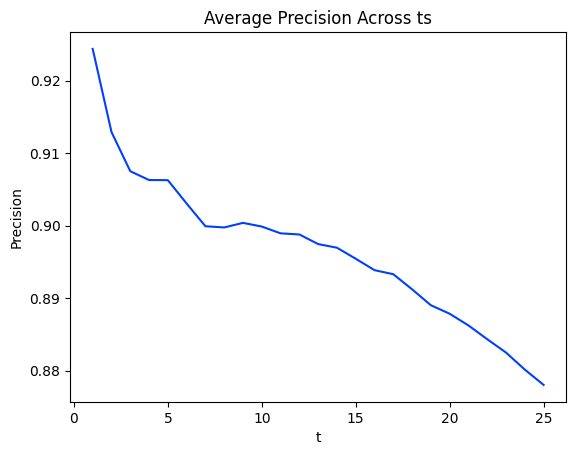

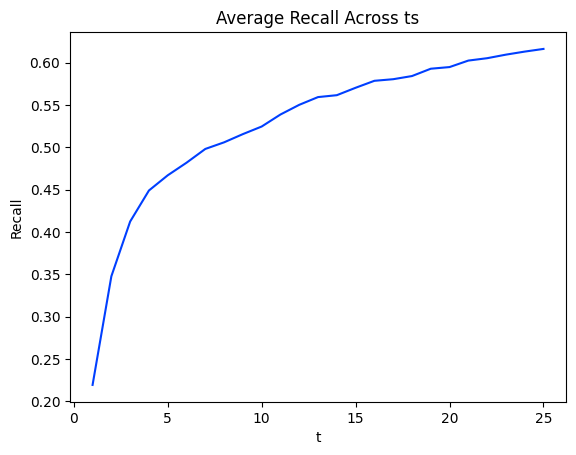

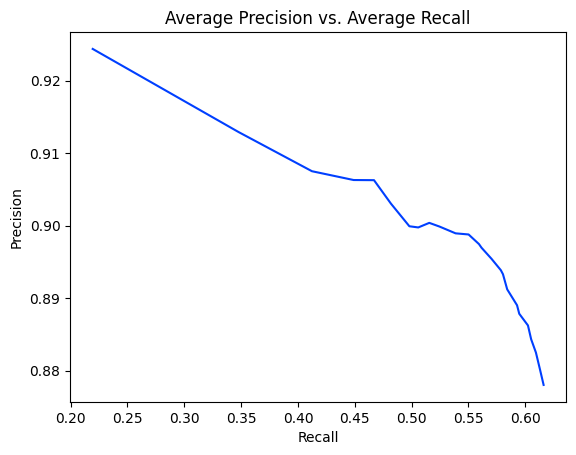

In [67]:
nmf_precisions, nmf_recalls = calc_precision_recall("nmf", ts)

##### MF

  0%|          | 0/25 [00:00<?, ?it/s]

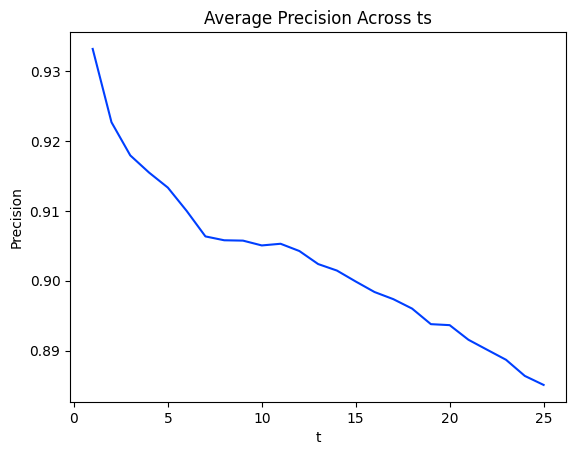

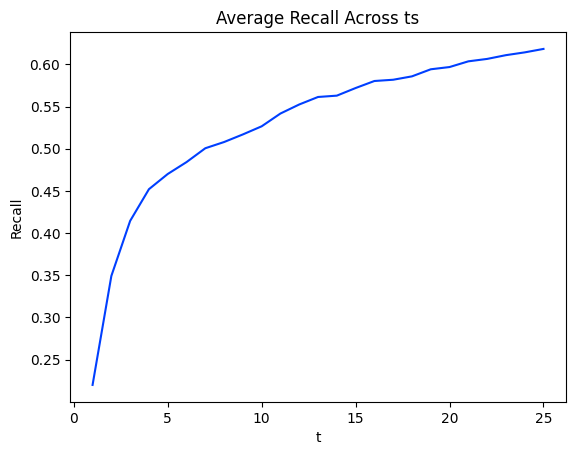

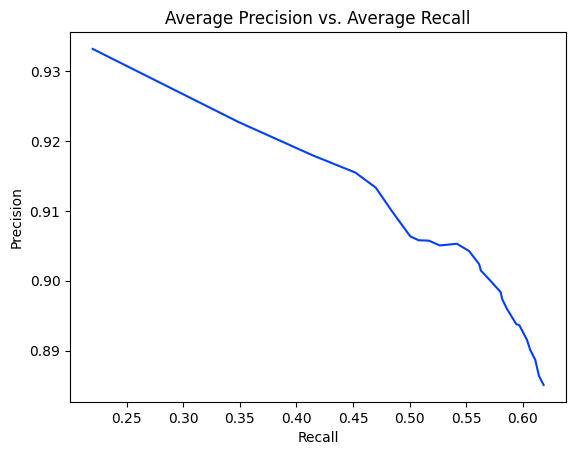

In [68]:
mfb_precisions, mfb_recalls = calc_precision_recall("mfb", ts)

#### • Plot the best precision-recall curves obtained for the three models (k-NN, NMF, MF) in the same figure. Use this figure to compare the relevance of the recommendation list generated using k-NN, NMF, and MF with bias predictions.
> Ans: MF with bias is the best model since given the same recall it always has the best precision.

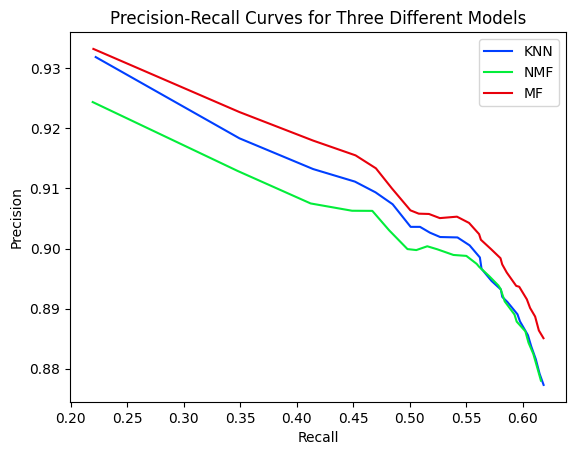

In [69]:
plt.plot(knn_recalls, knn_precisions, label="KNN")
plt.plot(nmf_recalls, nmf_precisions, label="NMF")
plt.plot(mfb_recalls, mfb_precisions, label="MF")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves for Three Different Models")
plt.legend(loc="upper right")
plt.show()